# DNN

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("Fully_cleaned.csv")

# Clean and preprocess
df['bed'] = pd.to_numeric(df['bed'], errors='coerce')
df['bath'] = df['bath'].replace(r'\+', '', regex=True)
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')
df = df.dropna(subset=['bed', 'bath', 'Safety_Score'])

# Target transformation
df['Property Value_log'] = np.log1p(df['Property Value'])

# Features and target split
X = df.drop(columns=['Property Value', 'Property Value_log'])
y = df['Property Value_log']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Replace inf/-inf, fill NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restoring the weights of the best epoch
)


2025-05-06 23:11:22.582603: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 23:11:22.736609: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 23:11:22.855004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746573083.055443    7506 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746573083.092406    7506 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746573083.346048    7506 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 24.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 61.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 55.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may ne

In [5]:


# DNN Model
# Standard protocols for regression tasks in deep learning include using a few dense layers with ReLU activations, dropout for regularization, 
# and a final linear layer for output.
model = keras.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01),input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(
                    X_train_scaled,
                    y_train,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stopping]
                    )

# Predict and evaluate
y_pred_log = model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f" RMSE: {rmse:,.2f}")
print(f" R² Score: {r2:.4f}")

Epoch 1/150


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 59.7017 - mae: 5.3841 - val_loss: 2.1262 - val_mae: 0.7527
Epoch 2/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8384 - mae: 0.9978 - val_loss: 1.9376 - val_mae: 0.7333
Epoch 3/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3869 - mae: 0.8780 - val_loss: 1.5509 - val_mae: 0.5765
Epoch 4/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1000 - mae: 0.8336 - val_loss: 1.6874 - val_mae: 0.7691
Epoch 5/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8871 - mae: 0.7985 - val_loss: 1.1300 - val_mae: 0.4603
Epoch 6/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6570 - mae: 0.7447 - val_loss: 1.6362 - val_mae: 0.8604
Epoch 7/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4560 - mae: 0.7023 - val_loss: 1.1577 - val_mae: 0.6381
Epoch 8/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1662 - mae: 0.6073 - val_loss: 1.2777 - val_mae: 0.7792
Epoch 9/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

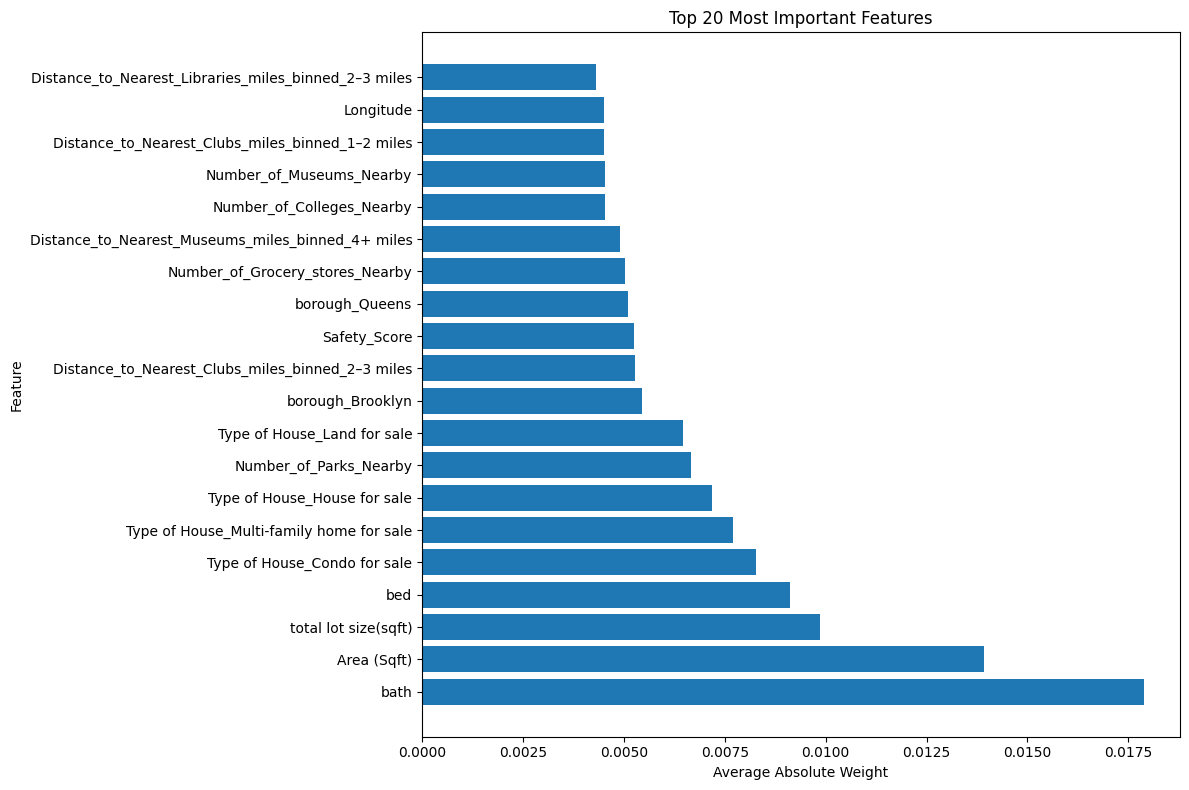


Top 20 Most Important Features:
                                              Feature  Importance
1                                                bath    0.017886
2                                         Area (Sqft)    0.013935
20                               total lot size(sqft)    0.009869
0                                                 bed    0.009118
24                       Type of House_Condo for sale    0.008265
30           Type of House_Multi-family home for sale    0.007702
28                       Type of House_House for sale    0.007195
5                              Number_of_Parks_Nearby    0.006653
29                        Type of House_Land for sale    0.006461
33                                   borough_Brooklyn    0.005440
50   Distance_to_Nearest_Clubs_miles_binned_2–3 miles    0.005275
22                                       Safety_Score    0.005262
35                                     borough_Queens    0.005105
18                    Number_of_Grocery_sto

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Calculate feature importance based on model weights
def get_feature_importance(model, feature_names):
    # Get weights from the first dense layer
    weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
    
    # Create a dataframe of features and their importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': weights
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df

# Get feature importance
feature_names = X_train.columns
importance_df = get_feature_importance(model, feature_names)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.title('Top 20 Most Important Features')
plt.xlabel('Average Absolute Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print numeric values for top 20 features
print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Calculate correlation with target variable for numeric features
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
correlations = pd.DataFrame({
    'Feature': numeric_features,
    'Correlation': [np.corrcoef(X_train[feat], y_train)[0,1] for feat in numeric_features]
})

print("\nFeature Correlations with Target (log price):")
print(correlations.sort_values('Correlation', ascending=False))

In [9]:
model.save('nyc_property_price_model.h5')

In [10]:
from sklearn.metrics import explained_variance_score

# Calculate explained variance score on log-transformed values
ev_score_log = explained_variance_score(y_test, y_pred_log)

# Calculate explained variance score on original scale
ev_score = explained_variance_score(y_true, y_pred)

print(f"Explained Variance Score (log scale): {ev_score_log:.4f}")
print(f"Explained Variance Score (original scale): {ev_score:.4f}")

Explained Variance Score (log scale): 0.8576
Explained Variance Score (original scale): 0.8524


In [11]:
print("Predictions:",y_pred_log)
print("\n Test:",y_test)

Predictions: [13.484518 14.658064 13.860592 ... 15.050798 13.411612 13.587378]

 Test: 5837    13.541074
7248    14.862830
8152    13.303019
3398    15.084695
7640    13.704580
          ...    
47      14.038655
1015    15.068274
3087    15.084695
8385    13.565768
8177    13.863349
Name: Property Value_log, Length: 1926, dtype: float64


In [13]:
print("Sample Predictions vs Actuals")
for pred, actual in zip(y_pred[:5], y_true[:5]):
    print(f"Predicted: ${pred:,.2f}, Actual: ${actual:,.2f}")


Sample Predictions vs Actuals
Predicted: $718,209.56, Actual: $759,999.00
Predicted: $2,322,288.00, Actual: $2,850,000.00
Predicted: $1,046,111.94, Actual: $599,000.00
Predicted: $3,115,351.25, Actual: $3,557,950.00
Predicted: $824,448.25, Actual: $895,000.00


In [14]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("Any NaNs in X_train_scaled?", np.isnan(X_train_scaled).any())
print("y_train min/max:", y_train.min(), y_train.max())


X_train_scaled shape: (7700, 86)
X_test_scaled shape: (1926, 86)
Any NaNs in X_train_scaled? False
y_train min/max: 10.819798284210286 15.084695375331187


In [15]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_log = model.predict(X_test_scaled).flatten()
print("RMSE (log):", np.sqrt(mean_squared_error(y_test, y_pred_log)))
print("R² Score (log):", r2_score(y_test, y_pred_log))


 1/61 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE (log): 0.3185749394356609
R² Score (log): 0.8532120632511333


In [16]:
mean_property_value = df['Property Value'].mean()
rmse_percentage = (rmse / mean_property_value) * 100

print(f"Mean Property Value: ${mean_property_value:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"RMSE as percentage of mean value: {rmse_percentage:.2f}%")

Mean Property Value: $1,601,079.78
RMSE: $430,831.33
RMSE as percentage of mean value: 26.91%


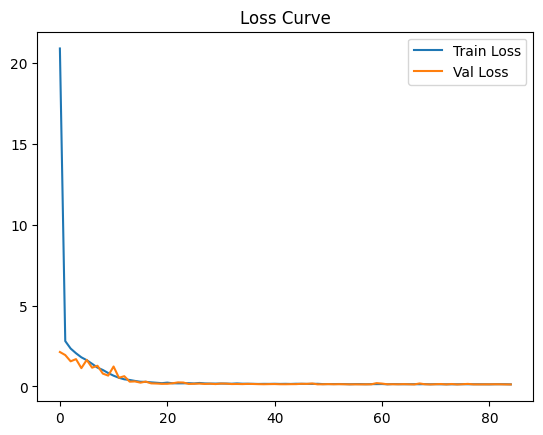

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

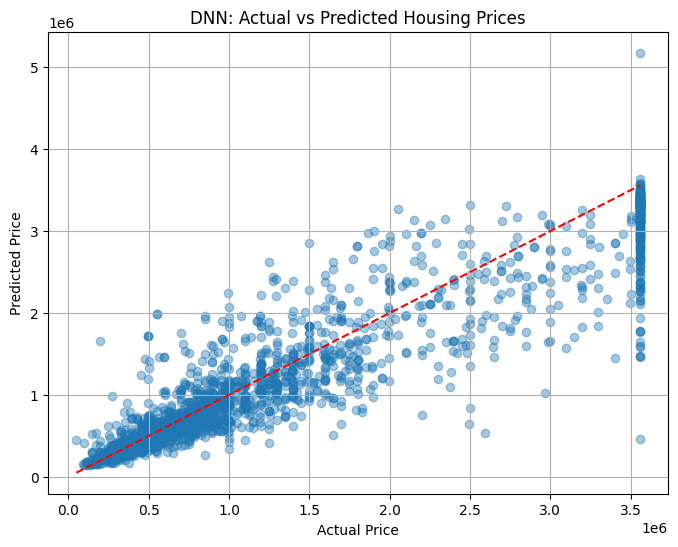

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("DNN: Actual vs Predicted Housing Prices")
plt.grid(True)
plt.show()

In [21]:
import keras_tuner as kt

def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units_input', 64, 512, step=64), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(layers.Dense(hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse', metrics=['mae'])
    return model


tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='house_price_prediction'
)

tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping])
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 59s]
val_loss: 0.10952670127153397

Best val_loss So Far: 0.10952670127153397
Total elapsed time: 00h 13m 35s


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"Input units: {best_hps.get('units_input')}")
print(f"Number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get("num_layers")):
    print(f"Units in layer {i}: {best_hps.get(f'units_{i}')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters:
Input units: 448
Number of layers: 4
Units in layer 0: 64
Units in layer 1: 64
Units in layer 2: 96
Units in layer 3: 192
Learning rate: 0.0001


In [23]:
# Predict on test set
y_pred_log = best_model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Tuned RMSE: {rmse:,.2f}")
print(f"Tuned R² Score: {r2:.4f}")


 1/61 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Tuned RMSE: 3,379,477.00
Tuned R² Score: -8.6665


# XGBOOST

[0]	validation_0-rmse:0.87180	validation_1-rmse:0.88401
[1]	validation_0-rmse:0.80308	validation_1-rmse:0.81491
[2]	validation_0-rmse:0.74211	validation_1-rmse:0.75473
[3]	validation_0-rmse:0.68708	validation_1-rmse:0.70025
[4]	validation_0-rmse:0.63849	validation_1-rmse:0.65213
[5]	validation_0-rmse:0.59646	validation_1-rmse:0.61057
[6]	validation_0-rmse:0.56116	validation_1-rmse:0.57558
[7]	validation_0-rmse:0.52792	validation_1-rmse:0.54226
[8]	validation_0-rmse:0.49946	validation_1-rmse:0.51524
[9]	validation_0-rmse:0.47361	validation_1-rmse:0.49086
[10]	validation_0-rmse:0.45084	validation_1-rmse:0.46952
[11]	validation_0-rmse:0.43076	validation_1-rmse:0.45105
[12]	validation_0-rmse:0.41274	validation_1-rmse:0.43517
[13]	validation_0-rmse:0.39738	validation_1-rmse:0.42123
[14]	validation_0-rmse:0.38509	validation_1-rmse:0.41059
[15]	validation_0-rmse:0.37258	validation_1-rmse:0.39944
[16]	validation_0-rmse:0.36130	validation_1-rmse:0.39013
[17]	validation_0-rmse:0.35195	validation

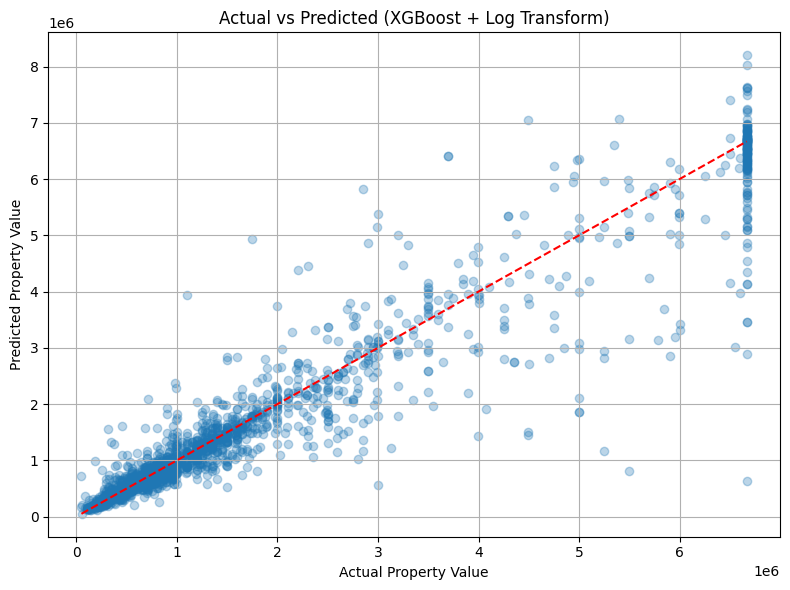

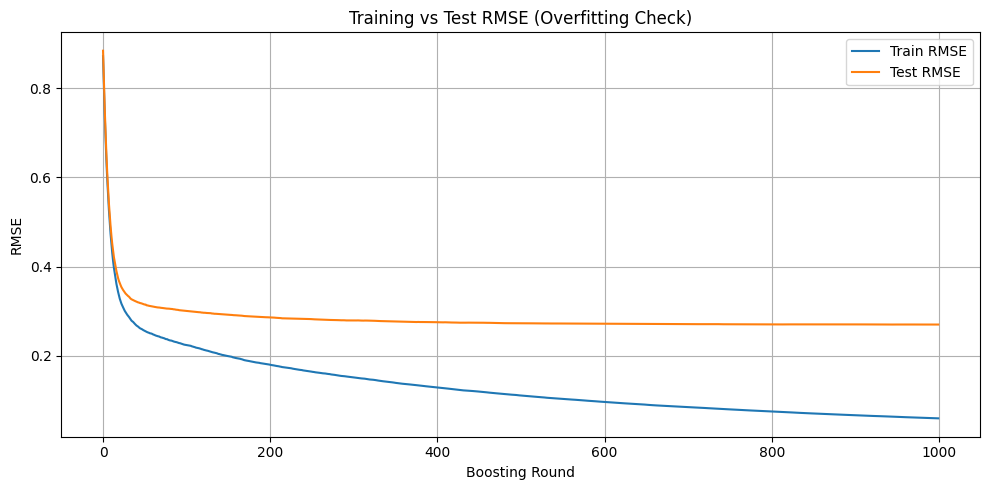

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# ---------- Step 1: Setup ----------
target = 'Property Value'

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove(target)  # Remove target from features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

X = df[categorical_cols + numerical_cols]
y = df[target]

# ---------- Step 2: Log-transform target ----------
y_log = np.log1p(y)

# ---------- Step 3: Split ----------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# ---------- Step 4: Preprocessing ----------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit the preprocessor and transform manually
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

import xgboost as xgb  # Make sure to import this too

# ---------- Step 5: XGBoost Model ----------
xgb_model = XGBRegressor(
    n_estimators=1000,          # Large number of estimators to allow early stopping
    learning_rate=0.1,          # Learning rate
    max_depth=6,                # Pruning: Limit tree depth
    subsample=0.8,              # Subsample ratio of the training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    random_state=42,            # Random seed for reproducibility
    eval_metric='rmse'
)

# ---------- Step 6: Train using callbacks ----------
xgb_model.fit(
    X_train_transformed, y_train_log,
    eval_set=[(X_train_transformed, y_train_log), (X_test_transformed, y_test_log)],  # Add evaluation sets
    verbose=True
)

# ---------- Step 7: Predict and Evaluate ----------
y_pred_log = xgb_model.predict(X_test_transformed)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test_log)

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"XGBoost with Overfitting Check:")
print(f"--------------------------------")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# ---------- Step 8: Plot Actual vs Predicted ----------
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.3)
plt.xlabel("Actual Property Value")
plt.ylabel("Predicted Property Value")
plt.title("Actual vs Predicted (XGBoost + Log Transform)")
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Step 9: Plot RMSE over boosting rounds ----------
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), results['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(epochs), results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Training vs Test RMSE (Overfitting Check)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
